# Label annotating for human breast cancer dataset

In [1]:
import stSCI
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from stSCI.utils.downstream import find_BCD

## Data preprocessing

In [2]:
sc_adata = sc.read('data/human_brest_cancer/human_bc_scrna.h5ad')
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [3]:
st_adata = sc.read_visium('data/human_brest_cancer/hbc')
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)

## Model training
For label inference, user need to set the `deconvolution` parameter to `True`.

In [4]:
sc_adata, st_adata = stSCI.train(sc_adata, st_adata, cluster_key='celltype_minor', clustering=True, deconvolution=True)

>>> INFO: Filtered 0 genes.
>>> INFO: Find 3000 same HVGs, result data shapes: [(40000, 3000), (2518, 3000)].
>>> INFO: Generate 17626 edges, 6.000 edges per spot (0.01s).
>>> INFO: Finish PCA (1.95s).
>>> INFO: Finish centroid generation (6.04s).
>>> INFO: Finish centroid generation (0.05s).


>>> Train stSCI: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s]


>>> INFO: Generate 107266 MNN pairs, 2.682 pairs per SC cell; 42.600 pairs per ST spot (1.46s).
>>> INFO: Finish generate deconvolution result (0.18s).
>>> INFO: Train stSCI model (118.42s).


## Generate the correlation matrix

We utilize the matrix generated from deconvolution results and categorize it by the clustering results to form the correlation matrix. To clearly illustrate the correlation of T cells within SC data, we specifically extract and visualize the portion of the correlation matrix for SC T cells. The correlation matrix shows that cluster 4, 5, 8 is high correlated with T cell.

<Axes: >

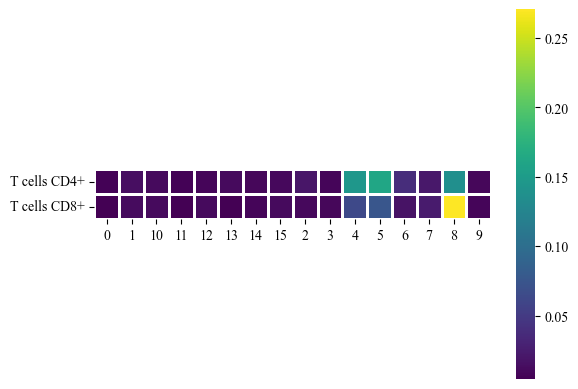

In [5]:
cluster_list = np.unique(st_adata.obs['cluster_result'])
sim_matrix = np.array([
    np.mean(st_adata.obsm['decon_result'][cluster == st_adata.obs['cluster_result']], axis=0) 
    for cluster in cluster_list
])
sim_df = pd.DataFrame(sim_matrix, index=cluster_list, columns=st_adata.obsm['decon_result'].columns)
sns.heatmap(sim_df[['T cells CD4+', 'T cells CD8+']].T, square=True, cmap='viridis', linewidths=2, linecolor='white')

## BCD validation

Finally, we employ the BCD method for validation. The results from the BCD (4, 5, 8) are consistent with those observed in the correlation matrix and the distribution of the marker gene.

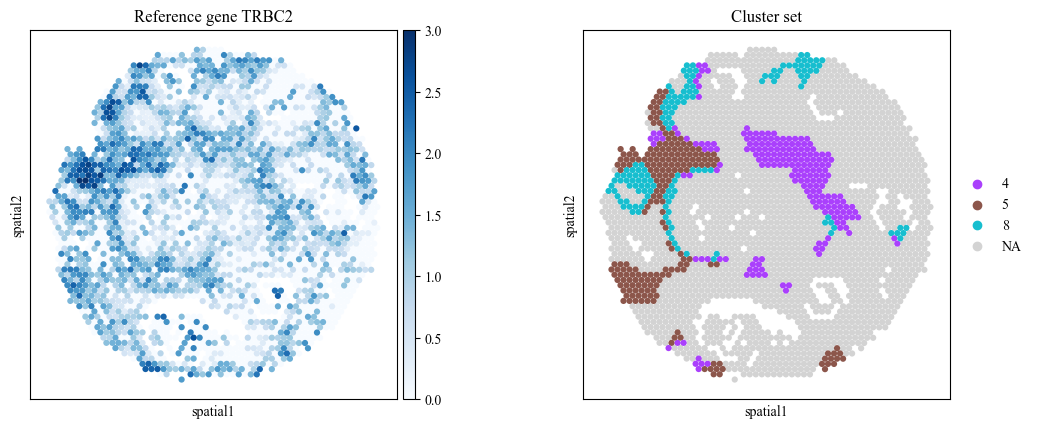

(['5', '8', '4'], 0.464046052394142)

In [6]:
find_BCD(st_adata, 'TRBC2', img_key=None, spot_size=300)